<img style="float: right; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="350px" height="180px" /> 


# <font color= 'navy'> EDA - Desempleo en USA -  Parte II</font>
### <font color= #2E9AFE> Ética para la Ciencia de Datos</font>


- <Strong> José Manuel Haces López - 734759</Strong>


- <Strong> Claudia Celeste Castillejos Jáuregui - 735868 </Strong>


- <Strong> Marcela Quintero Perez - 717644 </Strong>


- <Strong> Pablo Ivan Orosco Beltran - 723252 </Strong>


<Strong> Fecha </Strong>:  24 de febrero 2023.


### <font color= #2E9AFE> Apéndice </font>

- Portada.
- Descripción de la base de datos.
- Objetivo.
- Desarrollo.
- Conclusiones.

### <font color= #2E9AFE>2. Descripción de la base de datos </font>

Como segunda parte del proyecto final de Ética para la Ciencia de Datos trabajaremos con otra base de datos que nos proporcionó la maestra con el fin de poner en practica nuestros conocimientos acerca del modelado de datos supervisados.

Este conjunto de datos también contiene datos contiene información en promedio de los ingresos que adquiere un empleado en USA.

Las variables que contiene el dataset son:

    - gender
    - race
    - ResId
    - income_cat
    - educ
    - voter_category
    

### <font color= #2E9AFE>3. Objetivos </font>

 * Conocer cuanto es el ingreso promedio en USA.
 * Identificar las caracteristicas de los perfiles con mayor y menor salario.
 * Analizar el ingreso segregando por grupos (sociales, genero, raza, etc.)

### <font color= #2E9AFE>4. Desarrollo</font>
### <font color= #2E9AFE> EDA </font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def autolabel(rects, ax):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.,
                1.05*height,
                '%d'%int(height),
                ha='center', va='bottom')
        
def _get_colors_to_use(variables):
    """ Set colors to elements of a list.

    Parameters
    ----------
    variables: list
        List of elements to assign a color to.

    Returns
    -------
    dict
        {element: color}
    """
    colors = plt.cm.jet(np.linspace(0, 1, len(variables)))
    return dict(zip(variables, colors))

class VariableAnalysis:
    def __init__(self, df, pattern, exception_patterns=[], extra_cols=None):
        # Initializing class
        self.df = df
        self.pattern = pattern
        self.extra_cols = extra_cols
        self.exception_patterns = exception_patterns
        self.data_transformed = False
    
    @staticmethod
    def _clean_columns(df):
        df.columns = [str(s).strip().replace(' ', '_')
              for s in df.columns]
        return df
    
    @staticmethod
    def _replace_valus_on_specific_columns(df, patterns,
                                           exception_patterns,
                                           extra_cols_with_no_pattern):

        if extra_cols_with_no_pattern is None:
            extra_cols_with_no_pattern = []
            
        # Setting columns on a given pattern
        pattern_cols = []
        
        # Getting pattern from all pattern columns
        for pattern in patterns:
            found_columns = [c for c in df.columns if pattern in c]
            
            # Removing columns that share specific pattern 
            for found_column in found_columns:
                for exception_pattern in exception_patterns:
                    if exception_pattern in found_column:
                        found_columns.remove(found_column)
                
            pattern_cols += found_columns        
        
        pattern_cols += extra_cols_with_no_pattern

        # Setting object columns
        object_cols = df.select_dtypes(include=['object']).columns

        # Go through every column that relates to money
        for pattern_col in pattern_cols:
            
            # Check that column actually is object type
            if pattern_col in object_cols:
                
                # Replace characters
                df[pattern_col] = df[pattern_col].apply(
                    lambda x: x.strip().replace(
                        '$','').replace(
                        ',', '').replace('%', '')
                    
                    if isinstance(x, str)
                    else x)
                
                # There's an special character (empty string), replace with None
                df[pattern_col].replace({'': None,
                                        '  -   ': None,
                                        '-': None,
                                        'N.A.': None,
                                        'S/D': None}, inplace=True)
                
                # Make sure every column now is a float64 type
                df[pattern_col] = df[pattern_col].astype('float64')
                
        return df
    
    @staticmethod
    def _basic_stats_for_numerical_variables(df):
        # Select numeric frame
        numeric_df = df.select_dtypes(include=['float64', 'int64'])
        
        stats = {}
        for numeric_column in numeric_df.columns:
            # Get mean
            mean = numeric_df[numeric_column].mean()
            
            # Get median
            median = numeric_df[numeric_column].median()
            
            # Get standard deviation
            std = numeric_df[numeric_column].std()
            
            # Get first and third quantile
            quantile25, quantile75 = numeric_df[numeric_column].quantile(
                q=[0.25, 0.75])
            
            # Get null count
            null_count = 100 * (numeric_df[numeric_column].isnull().sum() / len(numeric_df))
            
            # Put everything into a dict
            stats[numeric_column] = {'mean': mean,
                                    'median': median,
                                    'std': std,
                                    'q25': quantile25,
                                    'q75': quantile75,
                                    'nulls': null_count
                                    }
        return stats
    
    @staticmethod
    def _basic_stats_for_object_variables(df):
        # Select object frame
        object_df = df.select_dtypes(include=['object'])
        
        stats = {}
        for object_column in object_df.columns:
            # Unique values
            unique_vals = len(object_df[object_column].unique())
            
            # Mode
            all_values = object_df[object_column].value_counts()
            mode = (all_values.index[0],
                    100 * (all_values.values[0] / len(object_df)))
            
            # Null count
            null_count = (object_df[object_column].isnull().sum() / len(object_df)) * 100
            
            # Stats
            stats[object_column] = {'unique_vals': unique_vals,
                                   'mode': mode,
                                   'null_count': null_count}
            
            
        return stats
    
    def _fit(self):
        # Replacing values
        self.df = self._replace_valus_on_specific_columns(
            df=self.df, 
            patterns=self.pattern,
            exception_patterns=self.exception_patterns,
            extra_cols_with_no_pattern=self.extra_cols)
        
        self.df = self._clean_columns(df=self.df)
        return self
    
    def _transform(self):
        # Numeric stats
        numeric_stats = self._basic_stats_for_numerical_variables(
            df=self.df)
        
        # Object stats
        object_stats = self._basic_stats_for_object_variables(
            df=self.df)
        
        # Satefy boolean
        self.data_transformed = True
        return numeric_stats, object_stats, self.df
    
    def fit_transform(self):
        return self._fit()._transform()

    def plot_numeric(self, df, numeric_stats):
        if not self.data_transformed:
            raise ValueError('Data has not been prepared. \
            Execute method fit_transform in order to so.')
        
        corr = df.select_dtypes(exclude=['object']).corr()

        fig, ax = plt.subplots(figsize=(15, 15))
        ax.matshow(corr, cmap='Blues')

        ax.set_xticks(range(len(corr.columns)))
        ax.set_xticklabels(corr.columns, rotation=90)

        ax.set_yticks(range(len(corr.columns)))
        ax.set_yticklabels(corr.columns)

        ax.grid(False)

        metrics = ['mean', 'median','std', 'q25', 'q75','nulls']
        colors = _get_colors_to_use(metrics)
        
        for index, variable in enumerate(sorted(numeric_stats.keys())):

            # Plotting basic metrics
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

            bar_position = -1
            for metric, value in numeric_stats[variable].items():
                bar_position += 1

                if value is None or np.isnan(value):
                    value = -1

                # Plotting bars
                bar_plot = ax[0].bar(bar_position, value, 
                                     label=metric, color=colors[metric])
                autolabel(bar_plot, ax[0])


                # Plotting histogram
                df[variable].plot(kind='hist', color='blue',
                                          alpha=0.4, ax=ax[1])

                # Plotting boxplot
                df.boxplot(ax=ax[2], column=variable)

                ax[0].set_xticks(range(len(metrics)))
                ax[0].set_xticklabels(metrics, rotation=90)
                ax[2].set_xticklabels([], rotation=90)

                ax[0].set_title('\n Basic metrics \n', fontsize=10)
                ax[1].set_title('\n Data histogram \n', fontsize=10)
                ax[2].set_title('\n Data boxplot \n', fontsize=10)
                fig.suptitle(f'Variable: {variable} \n\n\n', fontsize=15)

                fig.tight_layout()
        return
    
    def plot_categorical(self, df, object_stats):
        if not self.data_transformed:
            raise ValueError('Data has not been prepared. \
            Execute method fit_transform in order to so.')
            
        metrics = ['unique_vals', 'mode', 'null_count']
        colors = _get_colors_to_use(metrics)

        for index, variable in enumerate(sorted(object_stats.keys())):

            # Plotting basic metrics
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

            bar_position = -1
            for metric, value in object_stats[variable].items():
                bar_position += 1

                if metric == 'mode':
                    mode = value[0]
                    value = value[1]

                if value is None or np.isnan(value):
                    value = -1

                bar_plot = ax.bar(bar_position, value, 
                                  label=metric, color=colors[metric])
                autolabel(bar_plot, ax)


            ax.set_xticks(range(len(metrics)))
            ax.set_xticklabels(metrics, rotation=90, fontsize=15)


            ax.set_title(f'\n Basic object metrics: {variable} \n Mode: {mode}\n',
                         fontsize=15)


            fig.tight_layout()
        return


In [3]:
# 1. Dataset de Desempleo por Grupos
# Cargando CSV
data = pd.read_csv("C:/Users/Castillejos/Sexto Semestre/Etica para la ciencia de datos/Proyecto_EticaCD/Data/Procesado/Nonvoters_Dataset.csv")
data.head()

,RespId,educ,race,gender,income_cat,voter_category
0,470001,College,White,Female,$75-125k,always
1,470002,College,White,Female,$125k or more,always
2,470003,College,White,Male,$125k or more,sporadic
3,470007,Some college,Black,Female,$40-75k,sporadic
4,480008,High school or less,White,Male,$40-75k,always


In [4]:
data.dtypes

RespId             int64
educ              object
race              object
gender            object
income_cat        object
voter_category    object
dtype: object

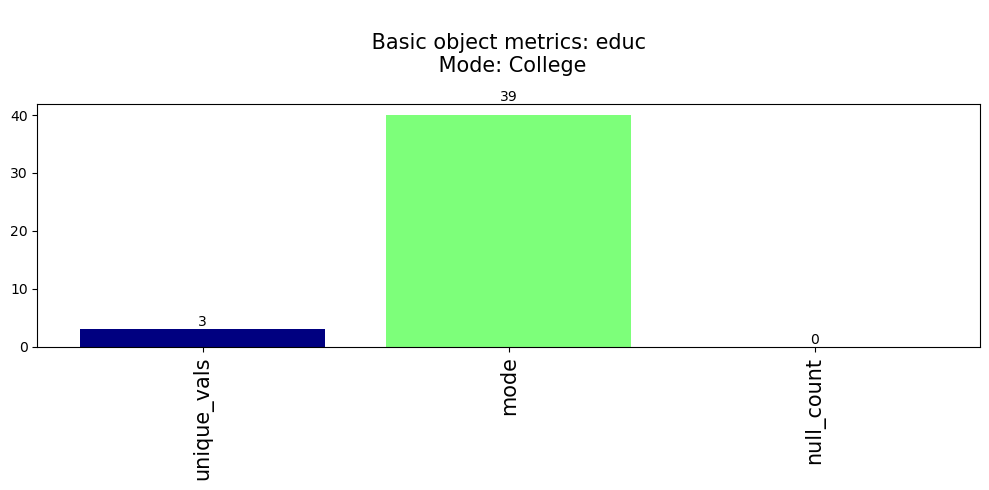

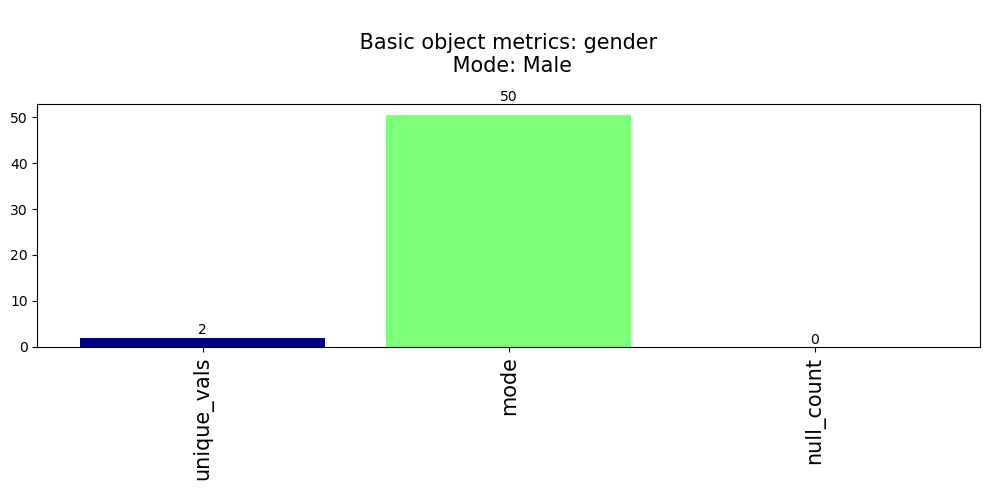

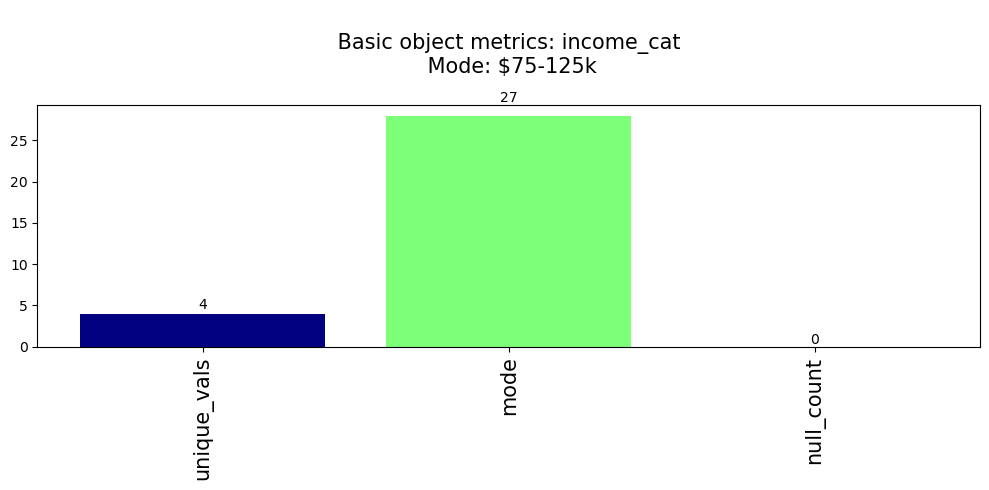

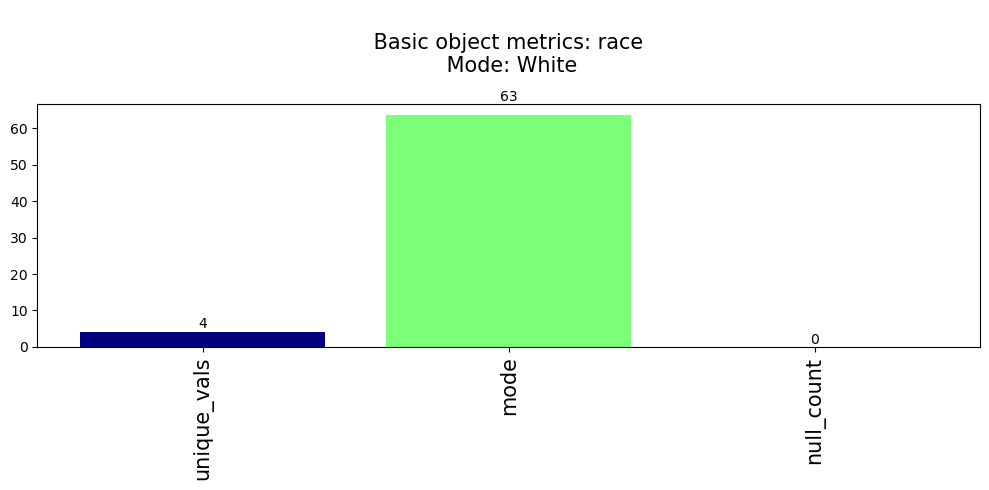

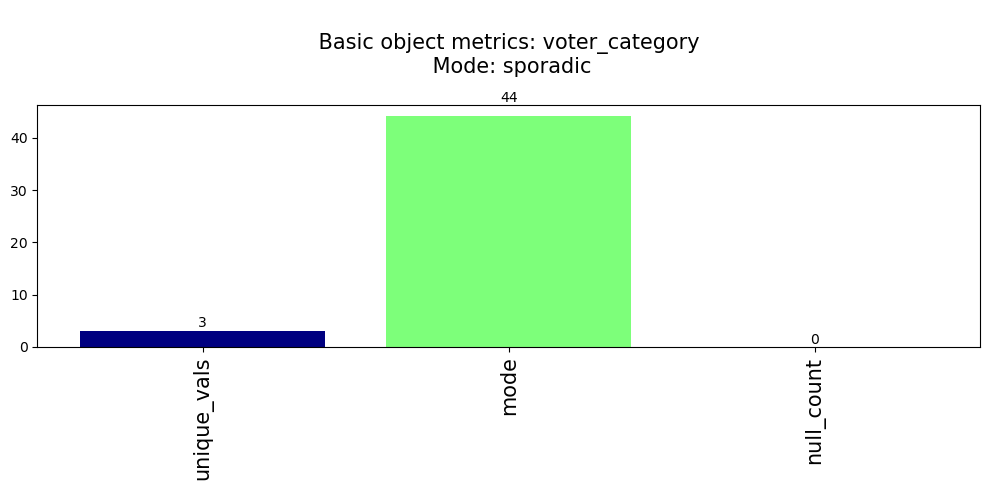

In [5]:
# Análisis Descriptivo
v_analysis = VariableAnalysis(df=data, pattern=[])
numeric_stats, object_stats, cleaned_df = v_analysis.fit_transform()
v_analysis.plot_categorical(df=data, object_stats=object_stats)

In [6]:
#Verificamos que no existan columnas con datos nulos
data.isnull().sum()

RespId            0
educ              0
race              0
gender            0
income_cat        0
voter_category    0
dtype: int64

In [7]:
#Variable de respuesta
data['income_cat'].unique()

array(['$75-125k', '$125k or more', '$40-75k', 'Less than $40k'],
      dtype=object)

In [8]:
#Reemplazamos $125k or more por 1,$75-125k por 2,'$40-75k' por 3 y  Less than $40k por 4 en la variable de respuesta.
data['income_cat'].mask(data['income_cat'] == '$125k or more',1,inplace=True)
data['income_cat'].mask(data['income_cat'] == '$75-125k',2,inplace=True)
data['income_cat'].mask(data['income_cat'] == '$40-75k',3,inplace=True)
data['income_cat'].mask(data['income_cat'] == 'Less than $40k',4,inplace=True)
#Cambiamos el tipo de variable int64
data['income_cat'] =data['income_cat'].astype('int64')

In [9]:
data.head()

,RespId,educ,race,gender,income_cat,voter_category
0,470001,College,White,Female,2,always
1,470002,College,White,Female,1,always
2,470003,College,White,Male,1,sporadic
3,470007,Some college,Black,Female,3,sporadic
4,480008,High school or less,White,Male,3,always


In [10]:
# Seleccionamos solo las variables categóricas
data_categorical = data.select_dtypes(include='object')
data_categorical.head()     

,educ,race,gender,voter_category
0,College,White,Female,always
1,College,White,Female,always
2,College,White,Male,sporadic
3,Some college,Black,Female,sporadic
4,High school or less,White,Male,always


In [11]:
#Hacemos dummies con ellas
dummies= pd.get_dummies(data_categorical)
dummies

,educ_College,educ_High school or less,educ_Some college,race_Black,race_Hispanic,race_Other/Mixed,race_White,gender_Female,gender_Male,voter_category_always,voter_category_rarely/never,voter_category_sporadic
0,1,0,0,0,0,0,1,1,0,1,0,0
1,1,0,0,0,0,0,1,1,0,1,0,0
2,1,0,0,0,0,0,1,0,1,0,0,1
3,0,0,1,1,0,0,0,1,0,0,0,1
4,0,1,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5831,0,0,1,0,1,0,0,0,1,1,0,0
5832,0,1,0,0,0,0,1,1,0,0,1,0
5833,1,0,0,0,0,1,0,0,1,0,0,1
5834,0,1,0,1,0,0,0,1,0,1,0,0


In [12]:
#Juntamos las variables anteriores
data2 =data.join(dummies)
data2

,RespId,educ,race,gender,income_cat,voter_category,educ_College,educ_High school or less,educ_Some college,race_Black,race_Hispanic,race_Other/Mixed,race_White,gender_Female,gender_Male,voter_category_always,voter_category_rarely/never,voter_category_sporadic
0,470001,College,White,Female,2,always,1,0,0,0,0,0,1,1,0,1,0,0
1,470002,College,White,Female,1,always,1,0,0,0,0,0,1,1,0,1,0,0
2,470003,College,White,Male,1,sporadic,1,0,0,0,0,0,1,0,1,0,0,1
3,470007,Some college,Black,Female,3,sporadic,0,0,1,1,0,0,0,1,0,0,0,1
4,480008,High school or less,White,Male,3,always,0,1,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831,477662,Some college,Hispanic,Male,3,always,0,0,1,0,1,0,0,0,1,1,0,0
5832,477663,High school or less,White,Female,1,rarely/never,0,1,0,0,0,0,1,1,0,0,1,0
5833,488322,College,Other/Mixed,Male,1,sporadic,1,0,0,0,0,1,0,0,1,0,0,1
5834,488325,High school or less,Black,Female,4,always,0,1,0,1,0,0,0,1,0,1,0,0


In [13]:
#Eliminamos las variables categóricas
dfc = data2.drop(columns=['educ','race','gender','voter_category'])
dfc

,RespId,income_cat,educ_College,educ_High school or less,educ_Some college,race_Black,race_Hispanic,race_Other/Mixed,race_White,gender_Female,gender_Male,voter_category_always,voter_category_rarely/never,voter_category_sporadic
0,470001,2,1,0,0,0,0,0,1,1,0,1,0,0
1,470002,1,1,0,0,0,0,0,1,1,0,1,0,0
2,470003,1,1,0,0,0,0,0,1,0,1,0,0,1
3,470007,3,0,0,1,1,0,0,0,1,0,0,0,1
4,480008,3,0,1,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831,477662,3,0,0,1,0,1,0,0,0,1,1,0,0
5832,477663,1,0,1,0,0,0,0,1,1,0,0,1,0
5833,488322,1,1,0,0,0,0,1,0,0,1,0,0,1
5834,488325,4,0,1,0,1,0,0,0,1,0,1,0,0


In [14]:
#Sesgo
skewness = round(dfc.skew(),2)
skewness = skewness.to_frame()
skewness = skewness.rename(columns={0: "value"}) 

def f(x):
    if x['value'] < -1 or x['value'] > 1: return 'Highly Skewed'
    elif (x['value']<=0 and x['value']>=-0.5) or (x['value'] >=0 and x['value']<=0.5):
        return 'Symmetric distribution'
    else: return 'Moderately skewed'
    
skewness['skewness'] = skewness.apply(f, axis=1)#axis=1 significa a todas los columnas

skewness

,value,skewness
RespId,1.61,Highly Skewed
income_cat,0.04,Symmetric distribution
educ_College,0.41,Symmetric distribution
educ_High school or less,0.83,Moderately skewed
educ_Some college,0.91,Moderately skewed
race_Black,1.86,Highly Skewed
race_Hispanic,2.08,Highly Skewed
race_Other/Mixed,3.52,Highly Skewed
race_White,-0.56,Moderately skewed
gender_Female,0.02,Symmetric distribution


In [15]:
from sklearn.model_selection import train_test_split
#Ahora separamos X y Y
X = dfc.drop(columns='income_cat', axis=0)
Y = dfc['income_cat']

#Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                  test_size = 0.2,
                                                  random_state=42)

In [16]:
#Normalizamos X_train y X_test de los datos 
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

C:\Users\Castillejos\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


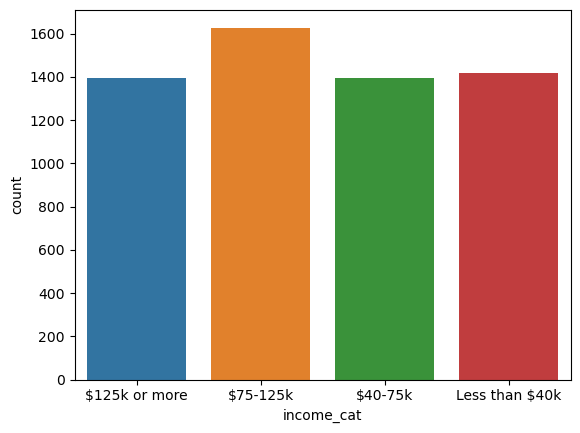

In [17]:
#Graficar >50K vs <=50K.
nuevo = dfc.copy()
nuevo['income_cat']=dfc['income_cat']
g = sns.countplot(nuevo['income_cat'])
g.set_xticklabels(['$125k or more','$75-125k', '$40-75k', 'Less than $40k'])
plt.show()

Las clases  se encuentran un tanto imbaleanceadas por lo tanto utilizaremos el método de sobremuestreo (Synthetic Minority Oversampling Technique) SMOTE.

Text(0.5, 1.0, 'Variable de salida')

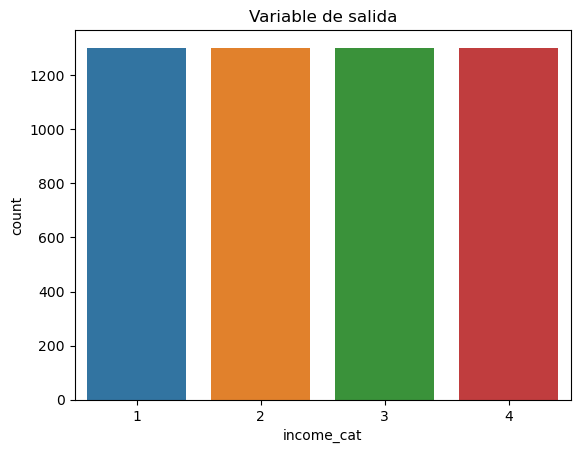

In [18]:
#Balanceamos los datos de salida usando algoritmo de SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
sns.countplot(x=y_train_res).set_title("Variable de salida")

In [19]:
#Conocemos todas las variables que tenemos 
X.columns.values

array(['RespId', 'educ_College', 'educ_High school or less',
       'educ_Some college', 'race_Black', 'race_Hispanic',
       'race_Other/Mixed', 'race_White', 'gender_Female', 'gender_Male',
       'voter_category_always', 'voter_category_rarely/never',
       'voter_category_sporadic'], dtype=object)